In [ ]:
results=[]

In [1]:
print('hello')

hello


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 25 21:54:18 2017

@author: lisu
"""
import soundfile as sf
import numpy as np
import scipy
import argparse
from keras.models import load_model
def STFT(x, fr, fs, Hop, h):        
    t = np.arange(Hop, np.ceil(len(x) / float(Hop)) * Hop, Hop)
    N = int(fs / float(fr))
    window_size = len(h)
    f = fs * np.linspace(0, 0.5, int(np.round(N / 2)), endpoint=True)
    Lh = int(np.floor(float(window_size - 1) / 2))
    tfr = np.zeros((int(N), len(t)), dtype=float)     

    for icol in range(len(t)):
        ti = int(t[icol])
        tau_min = int(-min([round(N / 2.0) - 1, Lh, ti - 1]))
        tau_max = int(min([round(N / 2.0) - 1, Lh, len(x) - ti]))
        tau_range = range(tau_min, tau_max)
        indices = np.mod(N + np.array(tau_range), N) + 1  
        # print("Shapes: indices - {}, x_slice - {}, h_slice - {}".format(indices.shape, x[ti + np.array(tau_range) - 1].shape, h[Lh + np.array(tau_range) - 1][:, np.newaxis].shape))
        x_slice = x[ti + np.array(tau_range) - 1][:, 0]  # Take only the first column
        h_slice = h[Lh + np.array(tau_range) - 1]
        tfr[indices - 1, icol] = x_slice * h_slice
    


    tfr = abs(scipy.fftpack.fft(tfr, n=N, axis=0))  
    return tfr, f, t,N


In [2]:
def nonlinear_func(X, g, cutoff):
    cutoff = int(cutoff)
    if g!=0:
        X[X<0] = 0
        X[:cutoff, :] = 0
        X[-cutoff:, :] = 0
        X = np.power(X, g)
    else:
        X = np.log(X)
        X[:cutoff, :] = 0
        X[-cutoff:, :] = 0
    return X

In [3]:
def Freq2LogFreqMapping(tfr, f, fr, fc, tc, NumPerOct):
    StartFreq = fc
    StopFreq = 1/tc
    Nest = int(np.ceil(np.log2(StopFreq/StartFreq))*NumPerOct)
    central_freq = []

    for i in range(0, Nest):
        CenFreq = StartFreq*pow(2, float(i)/NumPerOct)
        if CenFreq < StopFreq:
            central_freq.append(CenFreq)
        else:
            break

    Nest = len(central_freq)
    freq_band_transformation = np.zeros((Nest-1, len(f)), dtype=float)
    for i in range(1, Nest-1):
        l = int(round(central_freq[i-1]/fr))
        r = int(round(central_freq[i+1]/fr)+1)
        #rounding1
        if l >= r-1:
            freq_band_transformation[i, l] = 1
        else:
            for j in range(l, r):
                if f[j] > central_freq[i-1] and f[j] < central_freq[i]:
                    freq_band_transformation[i, j] = (f[j] - central_freq[i-1]) / (central_freq[i] - central_freq[i-1])
                elif f[j] > central_freq[i] and f[j] < central_freq[i+1]:
                    freq_band_transformation[i, j] = (central_freq[i + 1] - f[j]) / (central_freq[i + 1] - central_freq[i])
    tfrL = np.dot(freq_band_transformation, tfr)
    return tfrL, central_freq

In [4]:
def Quef2LogFreqMapping(ceps, q, fs, fc, tc, NumPerOct):
    StartFreq = fc
    StopFreq = 1/tc
    Nest = int(np.ceil(np.log2(StopFreq/StartFreq))*NumPerOct)
    central_freq = []

    for i in range(0, Nest):
        CenFreq = StartFreq*pow(2, float(i)/NumPerOct)
        if CenFreq < StopFreq:
            central_freq.append(CenFreq)
        else:
            break
    f = 1/q
    Nest = len(central_freq)
    freq_band_transformation = np.zeros((Nest-1, len(f)), dtype=float)
    for i in range(1, Nest-1):
        for j in range(int(round(fs/central_freq[i+1])), int(round(fs/central_freq[i-1])+1)):
            if f[j] > central_freq[i-1] and f[j] < central_freq[i]:
                freq_band_transformation[i, j] = (f[j] - central_freq[i-1])/(central_freq[i] - central_freq[i-1])
            elif f[j] > central_freq[i] and f[j] < central_freq[i+1]:
                freq_band_transformation[i, j] = (central_freq[i + 1] - f[j]) / (central_freq[i + 1] - central_freq[i])

    tfrL = np.dot(freq_band_transformation, ceps)
    return tfrL, central_freq

In [5]:
def CFP_filterbank(x, fr, fs, Hop, h, fc, tc, g, NumPerOctave):
    NumofLayer = np.size(g)

    tfr, f, t, N = STFT(x, fr, fs, Hop, h)
    tfr = np.power(np.abs(tfr), g[0])
    tfr0 = tfr.copy()  # original STFT
    ceps = np.zeros(tfr.shape)

    if NumofLayer >= 2:
        for gc in range(1, NumofLayer):
            if gc % 2 == 1:
                tc_idx = round(fs * tc)
                ceps = np.real(np.fft.fft(tfr, axis=0)) / np.sqrt(N)
                ceps = nonlinear_func(ceps, g[gc], tc_idx)
            else:
                fc_idx = round(fc / fr)
                tfr = np.real(np.fft.fft(ceps, axis=0)) / np.sqrt(N)
                tfr = nonlinear_func(tfr, g[gc], fc_idx)

    tfr0 = tfr0[:int(round(N / 2)), :]
    tfr = tfr[:int(round(N / 2)), :]
    ceps = ceps[:int(round(N / 2)), :]

    HighFreqIdx = int(round((1 / tc) / fr) + 1)
    f = f[:HighFreqIdx]
    tfr0 = tfr0[:HighFreqIdx, :]
    tfr = tfr[:HighFreqIdx, :]
    HighQuefIdx = int(round(fs / fc) + 1)
    q = np.arange(HighQuefIdx) / float(fs)
    ceps = ceps[:HighQuefIdx, :]

    tfrL0, central_frequencies = Freq2LogFreqMapping(tfr0, f, fr, fc, tc, NumPerOctave)
    tfrLF, central_frequencies = Freq2LogFreqMapping(tfr, f, fr, fc, tc, NumPerOctave)
    tfrLQ, central_frequencies = Quef2LogFreqMapping(ceps, q, fs, fc, tc, NumPerOctave)

    return tfrL0, tfrLF, tfrLQ, f, q, t, central_frequencies


In [6]:
def feature_extraction(filename):
    x, fs = sf.read(filename)
#    if x.shape[1]>1:
#        x = np.mean(x, axis = 1)
    x = scipy.signal.resample_poly(x, 16000, fs)
    fs = 16000.0 # sampling frequency
    x = x.astype('float32')
    Hop = 320 # hop size (in sample)
    h = scipy.signal.windows.blackmanharris(2049) # window size
 # window size
    fr = 2.0 # frequency resolution
    fc = 80.0 # the frequency of the lowest pitch
    tc = 1/1000.0 # the period of the highest pitch
    g = np.array([0.24, 0.6, 1])
    NumPerOctave = 48 # Number of bins per octave
    
    tfrL0, tfrLF, tfrLQ, f, q, t, CenFreq = CFP_filterbank(x, fr, fs, Hop, h, fc, tc, g, NumPerOctave)
    Z = tfrLF * tfrLQ
    return Z, t, CenFreq, tfrL0, tfrLF, tfrLQ

In [7]:
def patch_extraction(Z, patch_size, th):
    # Z is the input spectrogram or any kind of time-frequency representation
    M, N = np.shape(Z)    
    half_ps = int(np.floor(float(patch_size)/2))

    Z = np.append(np.zeros([M, half_ps]), Z, axis = 1)
    Z = np.append(Z, np.zeros([M, half_ps]), axis = 1)
    Z = np.append(Z, np.zeros([half_ps, N+2*half_ps]), axis = 0)

    M, N = np.shape(Z)
    
#    data = np.zeros([1, patch_size, patch_size])
#    mapping = np.zeros([1, 2])
    data = np.zeros([300000, patch_size, patch_size])
    mapping = np.zeros([300000, 2])
    counter = 0
    for t_idx in range(half_ps, N-half_ps):
        PKS, LOCS = findpeaks(Z[:,t_idx], th)
#        print('time at: ', t_idx)
        for mm in range(0, len(LOCS)):
            if LOCS[mm] >= half_ps and LOCS[mm] < M - half_ps and counter<300000:# and PKS[mm]> 0.5*max(Z[:,t_idx]):
                patch = Z[np.ix_(range(LOCS[mm]-half_ps, LOCS[mm]+half_ps+1), range(t_idx-half_ps, t_idx+half_ps+1))]
                patch = patch.reshape(1, patch_size, patch_size)
#                data = np.append(data, patch, axis=0)
#                mapping = np.append(mapping, np.array([[LOCS[mm], t_idx]]), axis=0)
                data[counter,:,:] = patch
                mapping[counter,:] = np.array([[LOCS[mm], t_idx]])
                counter = counter + 1
            elif LOCS[mm] >= half_ps and LOCS[mm] < M - half_ps and counter>=300000:
                print('Out of the biggest size. Please shorten the input audio.')
                
    data = data[:counter-1,:,:]
    mapping = mapping[:counter-1,:]
    Z = Z[:M-half_ps,:]
#    print(data.shape)
#    print(mapping.shape)
    return data, mapping, half_ps, N, Z


In [8]:
def patch_prediction(modelname, data, patch_size):
    data = data.reshape(data.shape[0], patch_size, patch_size, 1)
    model = load_model(modelname)
    pred  = model.predict(data)
    return pred


In [9]:
def contour_prediction(mapping, pred, N, half_ps, Z, t, CenFreq, max_method):
    PredContour = np.zeros(N)

    pred = pred[:,1]
    pred_idx = np.where(pred>0.5)
    MM = mapping[pred_idx[0],:]
#    print(MM.shape)
    pred_prob = pred[pred_idx[0]]
#    print(pred_prob.shape)
    MM = np.append(MM, np.reshape(pred_prob, [len(pred_prob),1]), axis=1)
    MM = MM[MM[:,1].argsort()]    
    
    for t_idx in range(half_ps, N-half_ps):
        Candidate = MM[np.where(MM[:,1]==t_idx)[0],:]
#        print(Candidate[:,2])
        if Candidate.shape[0] >= 2:
            if max_method == 'posterior':
                fi = np.where(Candidate[:,2]==np.max(Candidate[:,2]))
                fi = fi[0]
            elif max_method == 'prior':
                fi = Z[Candidate[:,0].astype('int'),t_idx].argmax(axis=0)
            fi = fi.astype('int')
#            print(fi)
            PredContour[Candidate[fi,1].astype('int')] = Candidate[fi,0] 
        elif Candidate.shape[0] == 1:
            PredContour[Candidate[0,1].astype('int')] = Candidate[0,0] 
    
    # clip the padding of time
    PredContour = PredContour[range(half_ps, N-half_ps)]
    
    for k in range(len(PredContour)):
        if PredContour[k]>1:
            PredContour[k] = CenFreq[PredContour[k].astype('int')]
    
    Z = Z[:, range(half_ps, N-half_ps)]
#    print(t.shape)
#    print(PredContour.shape)    
    result = np.zeros([t.shape[0],2])
    result[:,0] = t/16000.0
    result[:,1] = PredContour
    return result


In [10]:
def contour_pred_from_raw(Z, t, CenFreq):
    PredContour = Z.argmax(axis=0)
    for k in range(len(PredContour)):
        if PredContour[k]>1:
            PredContour[k] = CenFreq[PredContour[k].astype('int')]
    result = np.zeros([t.shape[0],2])
    result[:,0] = t/16000.0
    result[:,1] = PredContour
    return result

In [11]:
def show_prediction(mapping, pred, N, half_ps, Z, t):
    postgram = np.zeros(Z.shape)
    pred = pred[:,1]
    for i in range(pred.shape[0]):
        postgram[mapping[i,0].astype('int'), mapping[i,1].astype('int')] = pred[i]
    return postgram

In [12]:
def findpeaks(x, th):
    # x is an input column vector
    M = x.shape[0]
    pre = x[1:M - 1] - x[0:M - 2]
    pre[pre < 0] = 0
    pre[pre > 0] = 1

    post = x[1:M - 1] - x[2:]
    post[post < 0] = 0
    post[post > 0] = 1

    mask = pre * post
    ext_mask = np.append([0], mask, axis=0)
    ext_mask = np.append(ext_mask, [0], axis=0)
    
    pdata = x * ext_mask
    pdata = pdata-np.tile(th*np.amax(pdata, axis=0),(M,1))
    pks = np.where(pdata>0)
    pks = pks[0]
    
    locs = np.where(ext_mask==1)
    locs = locs[0]
    return pks, locs

In [36]:
def melody_extraction(infile, outfile):
    # melody_extraction(‘path1/input.wav’, ‘path2/output.txt’)
    patch_size = 25
    th = 0.5
    modelname = r"C:\Users\91978\Desktop\dataset_melodify\models\model3_patch25 (1)"
    max_method = 'posterior'
    print('Feature extraction of ' + infile)
    Z, t, CenFreq, tfrL0, tfrLF, tfrLQ = feature_extraction(infile)
    if max_method == 'raw':
        result = contour_pred_from_raw(Z, t, CenFreq)
        postgram = Z
    else:
        print('Patch extraction from %d frames' % (Z.shape[1]))
        data, mapping, half_ps, N, Z = patch_extraction(Z, patch_size, th)
        print('Predictions from %d patches' % (data.shape[0]))
        pred = patch_prediction(modelname, data, patch_size)
        result = contour_prediction(mapping, pred, N, half_ps, Z, t,\
                                    CenFreq, max_method)
        postgram = show_prediction(mapping, pred, N, half_ps, Z, t)
    np.savetxt(outfile, result)
    return result, postgram, Z, tfrL0, tfrLF, tfrLQ, t, CenFreq
    
if __name__== "__main__":
#    melody_extraction(infile, outfile)

#    infile = 'opera_fem4.wav'
#    outfile = 'opera_fem4'
#    result = melody_extraction(infile, outfile)
#    plt.figure(1)
#    plt.plot(result[:,0],result[:,1])
    
    parser = argparse.ArgumentParser(
        description="Melody extraction")
    parser.add_argument("InFile", type=str)
    parser.add_argument("OutFile", type=str)
    
    args = parser.parse_args()


usage: ipykernel_launcher.py [-h] InFile OutFile
ipykernel_launcher.py: error: the following arguments are required: OutFile


SystemExit: 2

In [136]:

import librosa

file_path = "D:\\inputs\\bhairavi_4.mp3"
audio_data, sampling_rate = librosa.load(file_path, sr=None)

output_file_path = "Desktop"

result_4, postgram, Z, tfrL0, tfrLF, tfrLQ, t, CenFreq=melody_extraction(file_path, output_file_path)

Feature extraction of D:\inputs\bhairavi_4.mp3


C:\Users\91978\AppData\Local\Temp\ipykernel_11444\609441136.py:9: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  h = scipy.signal.blackmanharris(2049) # window size
C:\Users\91978\AppData\Local\Temp\ipykernel_11444\2309854265.py:13: RuntimeWarning: divide by zero encountered in divide
  f = 1/q


Patch extraction from 2329 frames
Predictions from 31326 patches
979/979 [==============================] - 5s 5ms/step


In [137]:
results.append(result_4)

In [134]:
file_path_1 = "C:\\Users\\91978\\Desktop\\dataset_melodify\\input_audio\\bhairavi_1.wav"
file_path_2= "D:\\inputs\\Bhairavi_2.mp3"
file_path_3="D:\\inputs\\bhairavi_3.mp3"
file_path_4="D:\\inputs\\bhairavi_4.mp3"

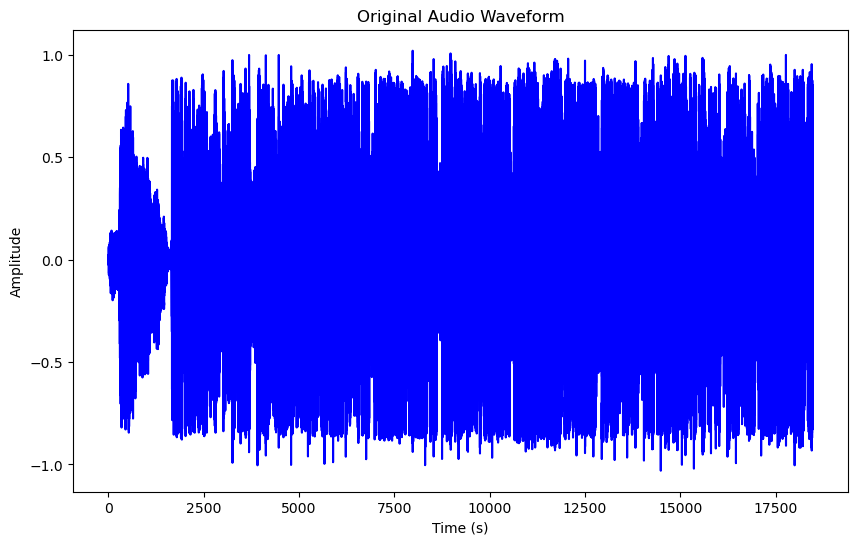

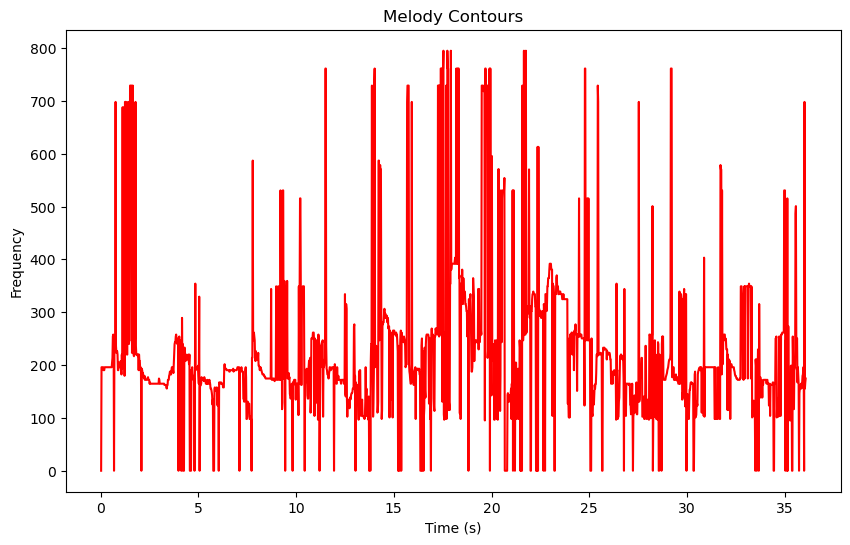

In [126]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_audio_with_melody(file_path, result):
    # Load the original audio file
    audio_data, sampling_rate = librosa.load(file_path, sr=None)

    # Create time axis for the audio waveform
    time_audio = librosa.times_like(audio_data, sr=sampling_rate)

    # Plot the original audio waveform
    plt.figure(figsize=(10, 6))
    plt.plot(time_audio, audio_data, color='blue')  # Plot audio waveform in blue

    # Optionally, add labels and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original Audio Waveform')
    plt.show()

    # Plot the melody contours
    plt.figure(figsize=(10,6))
    plt.plot(result[:, 0], result[:, 1], color='red')  # Plot melody contours in red

    # Optionally, add labels and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('Melody Contours')
    plt.show()

## plotting bhairavi_2
plot_audio_with_melody(file_path_2, result_2)


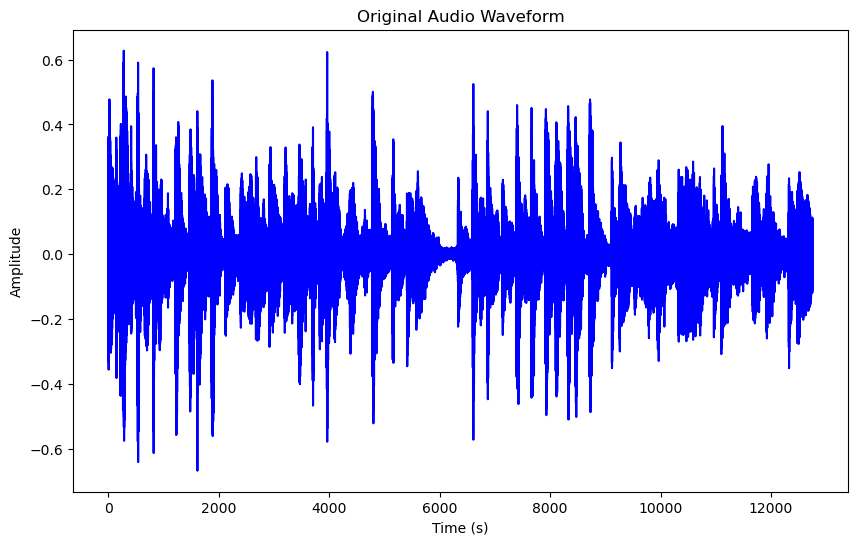

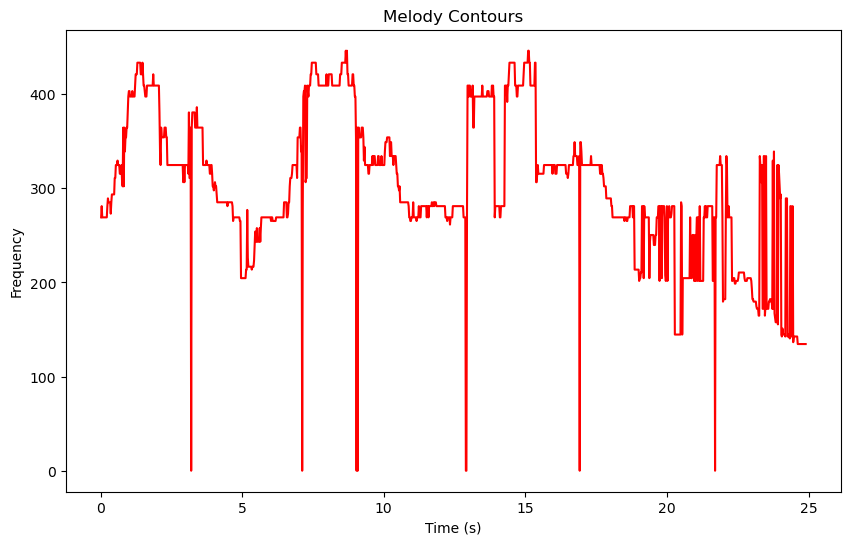

In [129]:
#plotting bhairavi_1
plot_audio_with_melody(file_path_1, result_1)

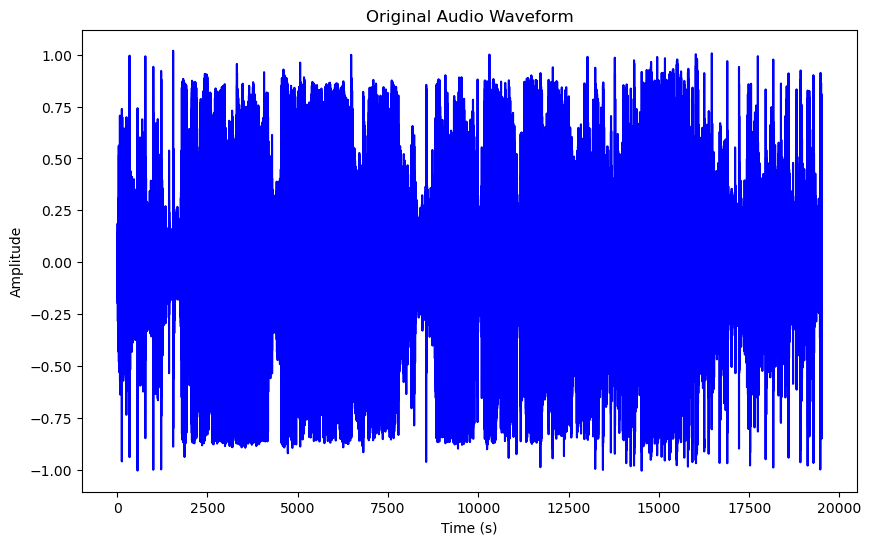

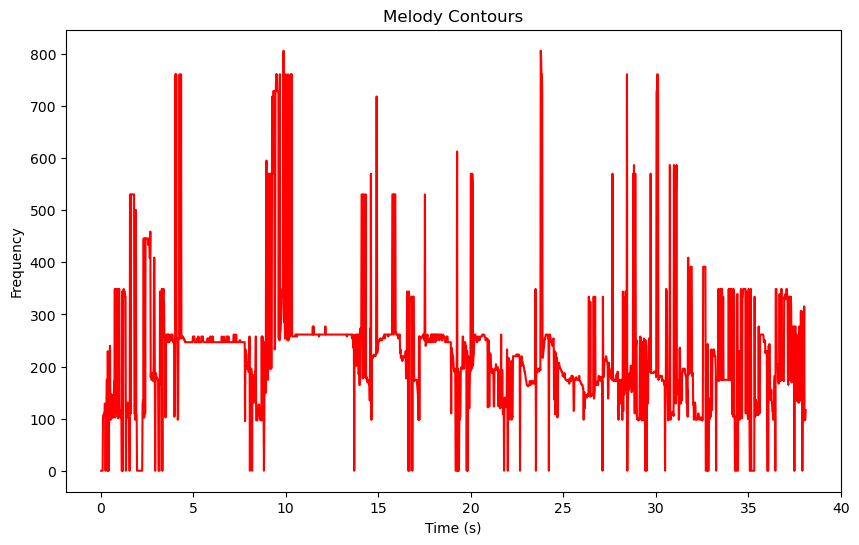

In [135]:
#plotting bhairavi_3
plot_audio_with_melody(file_path_3, result_3)

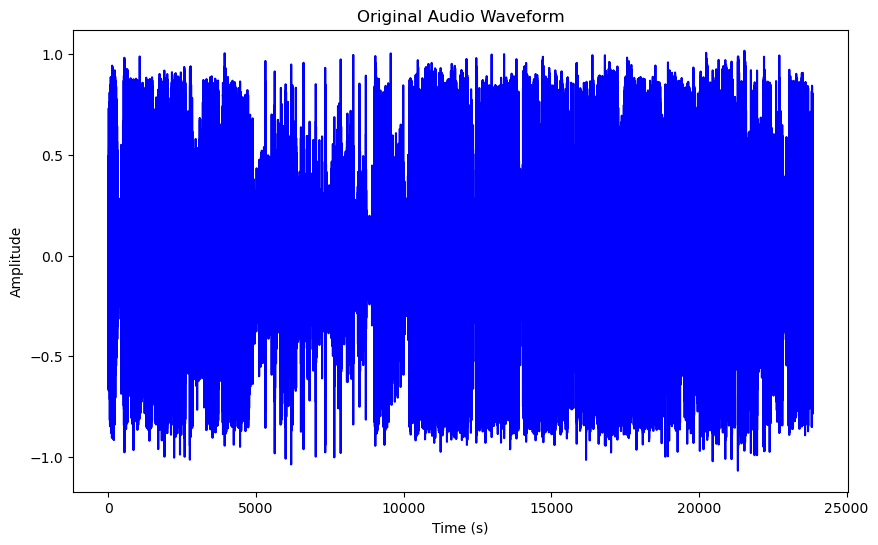

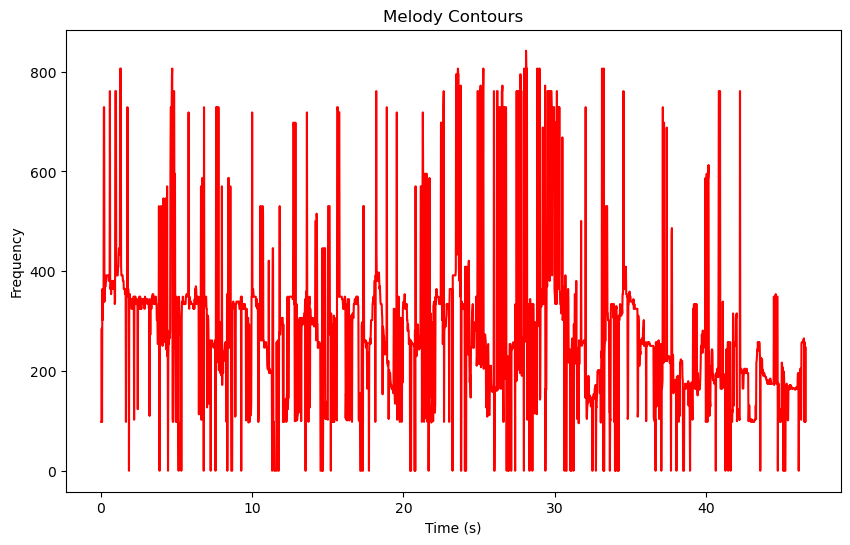

In [138]:
#plotting bhairavi_4
plot_audio_with_melody(file_path_4, result_4)

# superimposition of  contoutrs

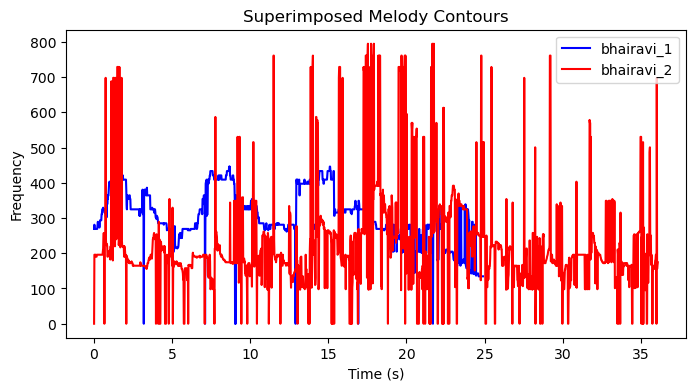

Percentage of superimposition: 0.10754915766455937


In [144]:
import matplotlib.pyplot as plt

def plot_superimposed_contours(contours1, contours2, label1='Contour 1', label2='Contour 2'):
    plt.figure(figsize=(8, 4))
    plt.plot(contours1[:, 0], contours1[:, 1], color='blue', label=label1)  # Plot contour 1 in blue
    plt.plot(contours2[:, 0], contours2[:, 1], color='red', label=label2)  # Plot contour 2 in red
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('Superimposed Melody Contours')
    plt.legend()
    plt.show()
    


def calculate_superimposition_percentage(contours1, contours2):
    # Calculate the intersecting area
    intersecting_area = 0
    for i in range(min(len(contours1), len(contours2)) - 1):
        x1 = max(contours1[i][0], contours2[i][0])
        x2 = min(contours1[i+1][0], contours2[i+1][0])
        if x2 > x1:
            y1 = max(contours1[i][1], contours2[i][1])
            y2 = min(contours1[i+1][1], contours2[i+1][1])
            if y2 > y1:
                intersecting_area += (x2 - x1) * (y2 - y1)

    # Calculate the total area covered by both contours
    total_area = max(contours1[-1][0], contours2[-1][0]) * max(contours1[-1][1], contours2[-1][1])

    # Calculate the percentage of superimposition
    superimposition_percentage = (intersecting_area / total_area) * 100

    return superimposition_percentage





plot_superimposed_contours(result_1, result_2,label1='bhairavi_1',label2='bhairavi_2')
percentage_superimposition = calculate_superimposition_percentage(result_1, result_2)
print("Percentage of superimposition:", percentage_superimposition)


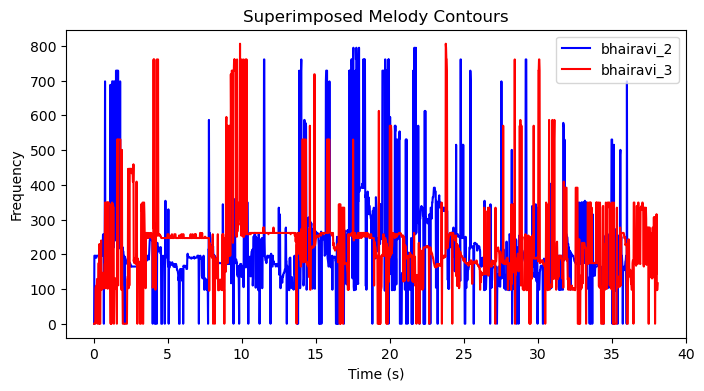

Percentage of superimposition: 0.49590420337694036


In [145]:
plot_superimposed_contours(result_2, result_3,label1='bhairavi_2',label2='bhairavi_3')
percentage_superimposition = calculate_superimposition_percentage(result_2, result_3)
print("Percentage of superimposition:", percentage_superimposition)


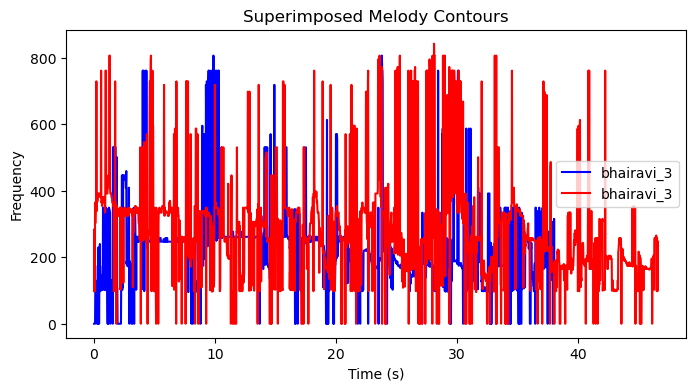

Percentage of superimposition: 0.6484795484060693


In [146]:
plot_superimposed_contours(result_3, result_4,label1='bhairavi_3',label2='bhairavi_3')
percentage_superimposition = calculate_superimposition_percentage(result_3, result_4)
print("Percentage of superimposition:", percentage_superimposition)


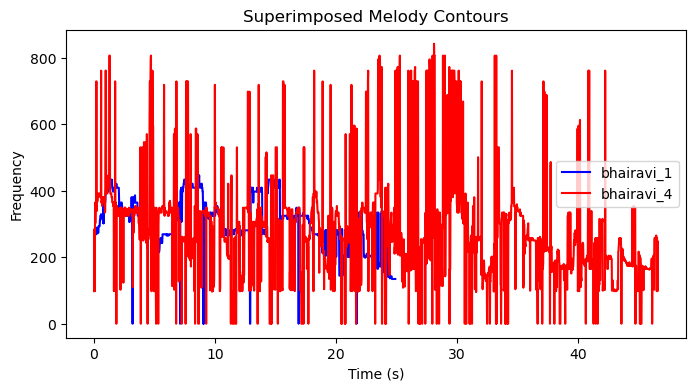

Percentage of superimposition: 0.07323236016474574


In [147]:
plot_superimposed_contours(result_1, result_4,label1='bhairavi_1',label2='bhairavi_4')
percentage_superimposition = calculate_superimposition_percentage(result_1, result_4)
print("Percentage of superimposition:", percentage_superimposition)


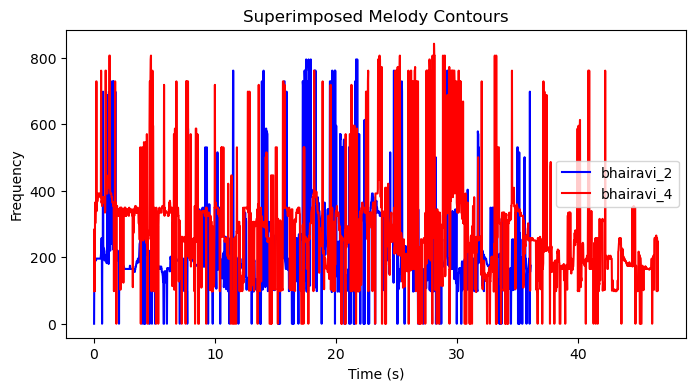

Percentage of superimposition: 0.5909907658340248


In [148]:
plot_superimposed_contours(result_2, result_4,label1='bhairavi_2',label2='bhairavi_4')
percentage_superimposition = calculate_superimposition_percentage(result_2, result_4)
print("Percentage of superimposition:", percentage_superimposition)


In [149]:
!git init

'git' is not recognized as an internal or external command,
operable program or batch file.
